<a href="https://colab.research.google.com/github/sensiboi/PRODIGY_ML/blob/main/PRODIGY_ML_TASK5_FoodCaloriesEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Food Calories Estimation**

In [5]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [6]:
print(tf.__version__)
print(tf.test.gpu_device_name())

2.17.0



In [7]:
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

In [8]:
get_data_extract()

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/

In [9]:
!ls food-101/

images	license_agreement.txt  meta  README.txt


In [10]:
os.listdir('food-101/images')

['edamame',
 'croque_madame',
 'breakfast_burrito',
 'peking_duck',
 'caprese_salad',
 'chicken_quesadilla',
 'fried_rice',
 'miso_soup',
 'beignets',
 'pork_chop',
 'samosa',
 'falafel',
 'waffles',
 'tuna_tartare',
 'donuts',
 'cup_cakes',
 'pulled_pork_sandwich',
 'hamburger',
 'pad_thai',
 'shrimp_and_grits',
 'foie_gras',
 'spaghetti_carbonara',
 'pho',
 'seaweed_salad',
 'creme_brulee',
 'cheese_plate',
 'crab_cakes',
 'french_onion_soup',
 'filet_mignon',
 'takoyaki',
 'prime_rib',
 'chocolate_cake',
 'dumplings',
 'caesar_salad',
 'huevos_rancheros',
 'apple_pie',
 'baklava',
 'hot_and_sour_soup',
 'grilled_salmon',
 'gyoza',
 'ceviche',
 'chicken_curry',
 'onion_rings',
 'french_fries',
 'ravioli',
 'tiramisu',
 'lobster_roll_sandwich',
 'garlic_bread',
 'macaroni_and_cheese',
 'bruschetta',
 'ramen',
 'clam_chowder',
 'carrot_cake',
 'gnocchi',
 'chicken_wings',
 'omelette',
 'greek_salad',
 'oysters',
 'club_sandwich',
 'steak',
 'frozen_yogurt',
 'spaghetti_bolognese',
 'be

In [11]:
os.listdir('food-101/meta')

['train.json',
 'test.json',
 'train.txt',
 'test.txt',
 'classes.txt',
 'labels.txt']

In [12]:
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [13]:
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


Visualise random image from each class

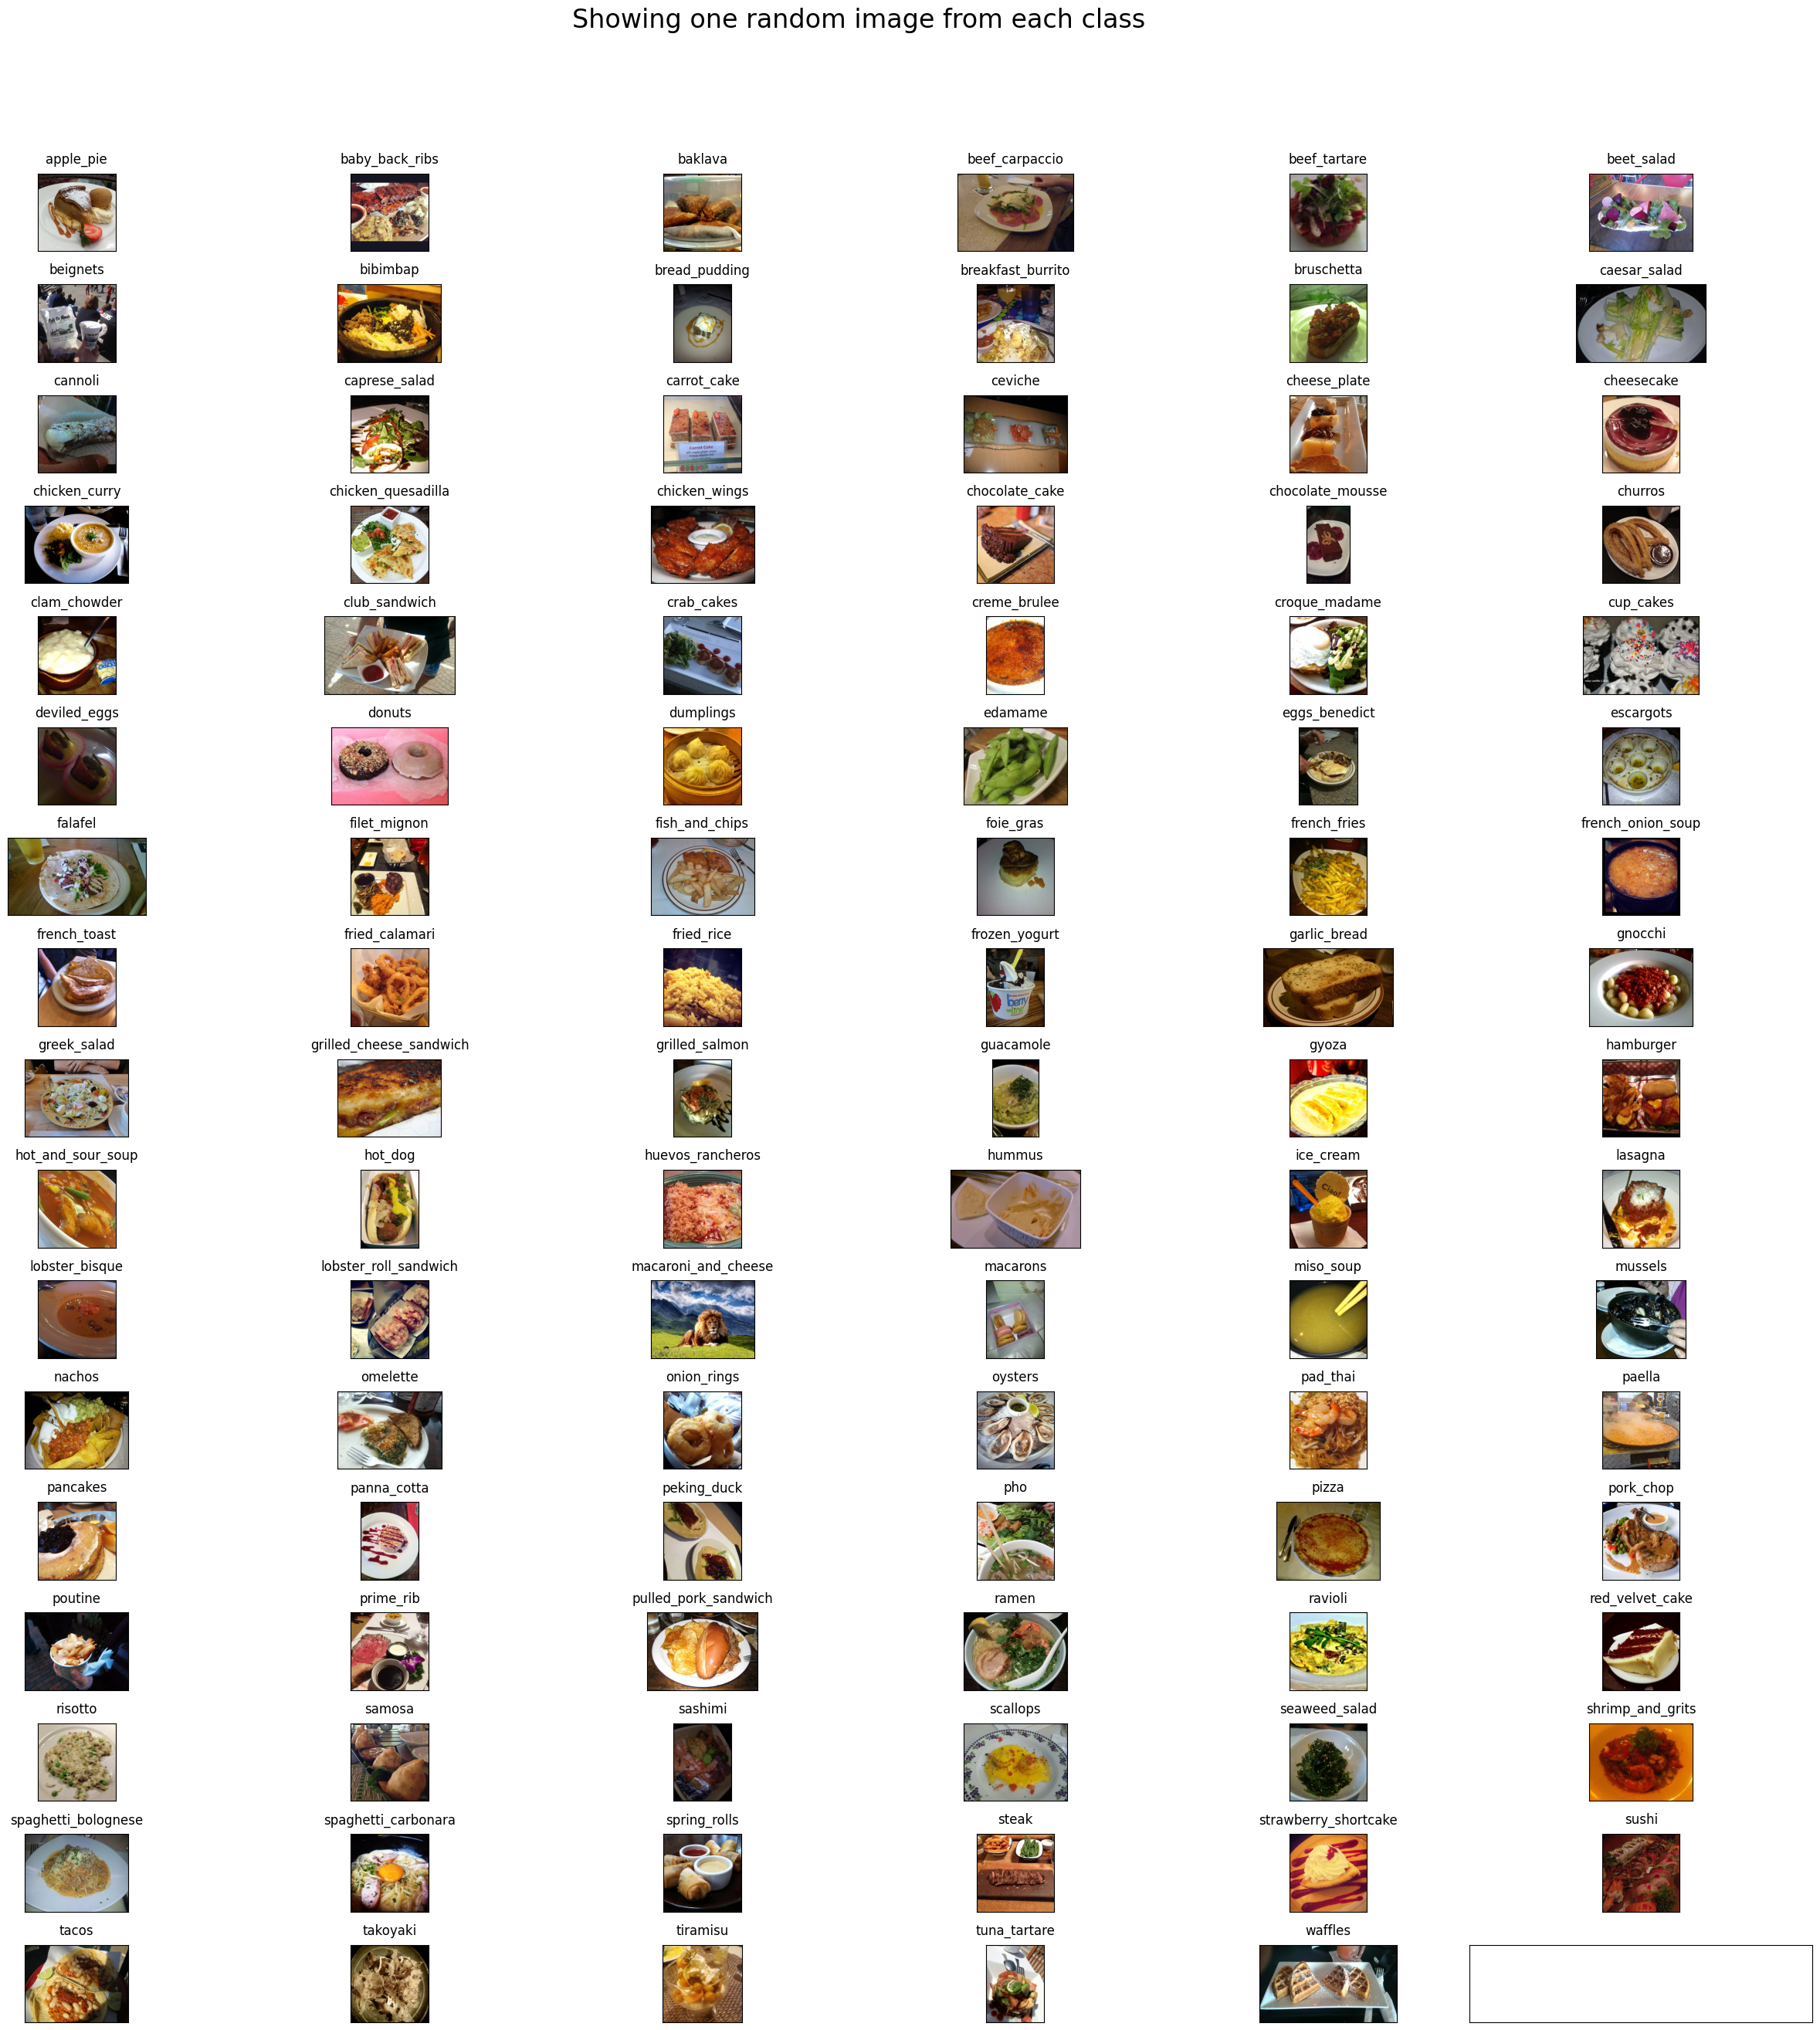

In [14]:
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id]
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)

plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

Split the data into train and test using traint.txt and test.txt

In [15]:
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")